## Урок 4  <a class='anchor' id='les4'>

1. Расскажите, как работает регуляризация в решающих деревьях, какие параметры мы штрафуем в данных алгоритмах?

Регуляризация - добавление штрафа за сложности модели. Штраф или ограничение накладывается на следующие параметры:
- максимальная глубина дерева;
- минимальное количество объектов в листе;
- максимальное количество листьев в дереве;
- минимальное число процентов, на которое должен улучшаться функционал качества при делении текущей подвыборки.

Это можно делать как во время построения дерева, так и после. Во втором случае дерево строится без ограничений, а потом удалаются вершины, чтобы дерево подходило под условия регуляризации.

2. По какому принципу рассчитывается "важность признака (feature_importance)" в ансамблях деревьев?

Расчет важности признака состоит из двух этапов:
1. Вычисление важности на каждом узле;
2. Вычисление важности каждого признака, используя критерии разделения на левое и правое поддерево на каждом узле.

Затем сумма важностей на узлах, которые разделяются по признаку, делится на сумму важностей всех узлов.

## Курсовой проект  <a class='anchor' id='prj'>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy.stats import probplot


def hist_qq(column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 9))
    ax1, ax2 = axes
    ax1.set_ylabel('Count')
    column.hist(ax=ax1)
    probplot(column,dist='norm',plot=ax2)
    plt.show()

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Количественные переменные**

In [4]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

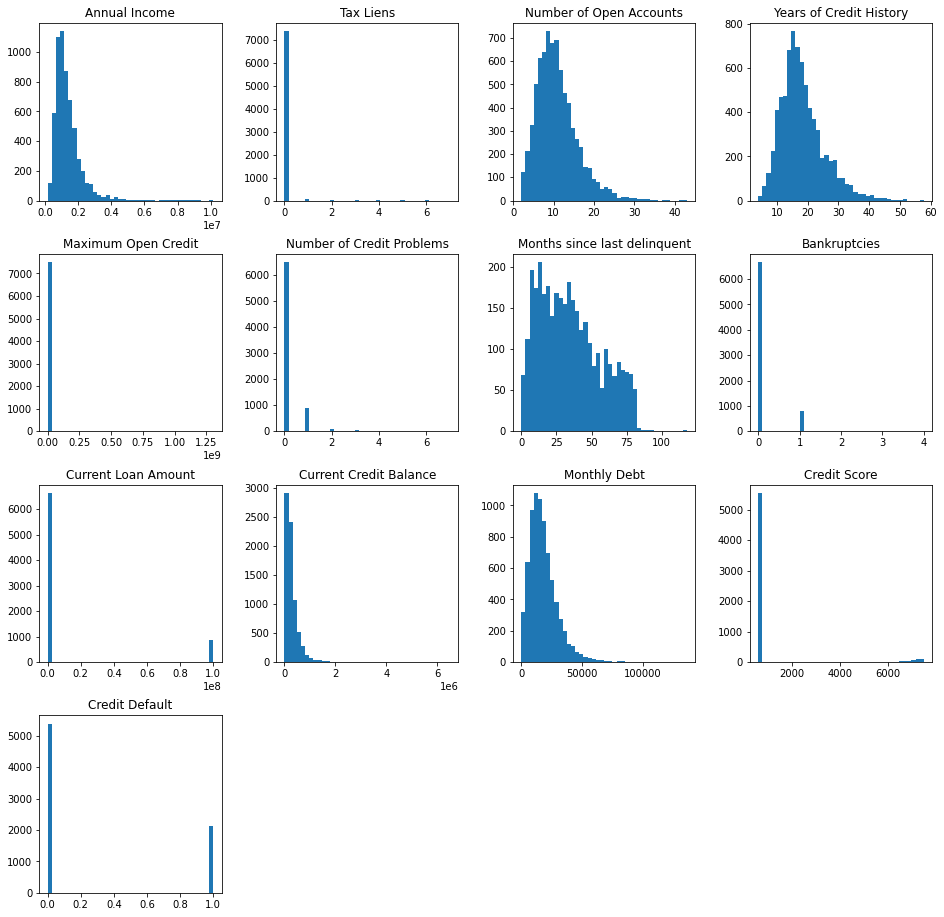

In [6]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])
df_num_features = df_num_features[df_num_features.columns]
df_num_features.hist(figsize=(16, 16), bins=40, grid=False)
plt.show()

**Выбросы**

Maximum Open Credit

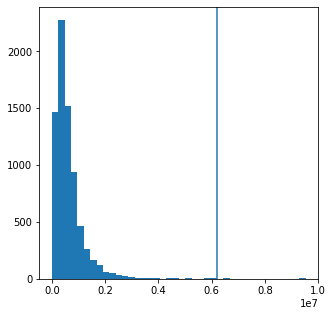

In [7]:
df_train.loc[df_train['Maximum Open Credit']<10**7, 'Maximum Open Credit'].hist(figsize=(5, 5), bins=40, grid=False)
plt.axvline(df_train['Maximum Open Credit'].quantile(.995))
plt.show()

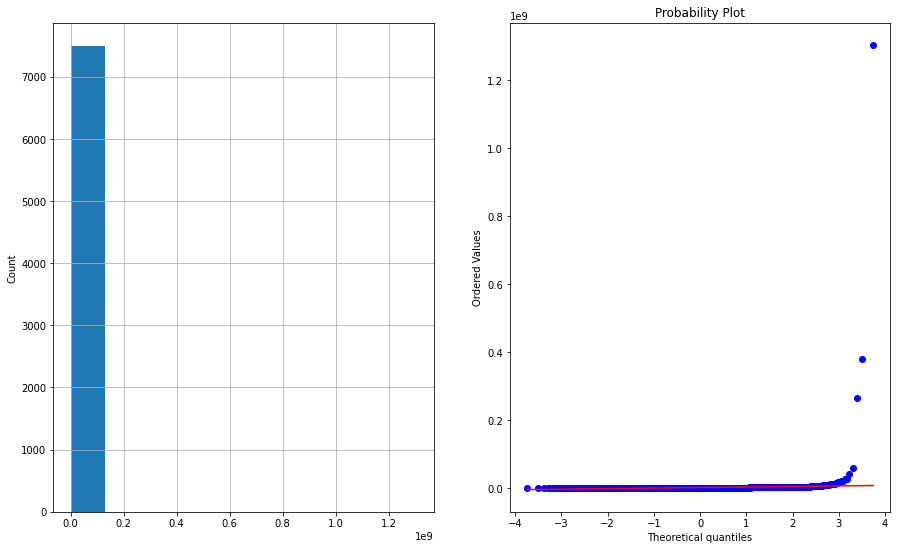

In [8]:
hist_qq(df_train['Maximum Open Credit'])

Ограничимся 0.995 квантилем. 

**Категориальные признаки**

In [9]:
categorial_features = df_train.select_dtypes(include='object').columns.tolist()
for categorial_feature in categorial_features:
    print(categorial_feature, df_train[categorial_feature].unique())

Home Ownership ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
Years in current job [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']
Purpose ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']
Term ['Short Term' 'Long Term']


Признак Term можно бинаризовать. Years in current job просто превратим в числовой, убрав слово years и знаки. Purpose: каждому значению назначим индекс. К Home Ownership остальным применим one hot encoding.

<Axes: xlabel='Purpose', ylabel='Credit Default'>

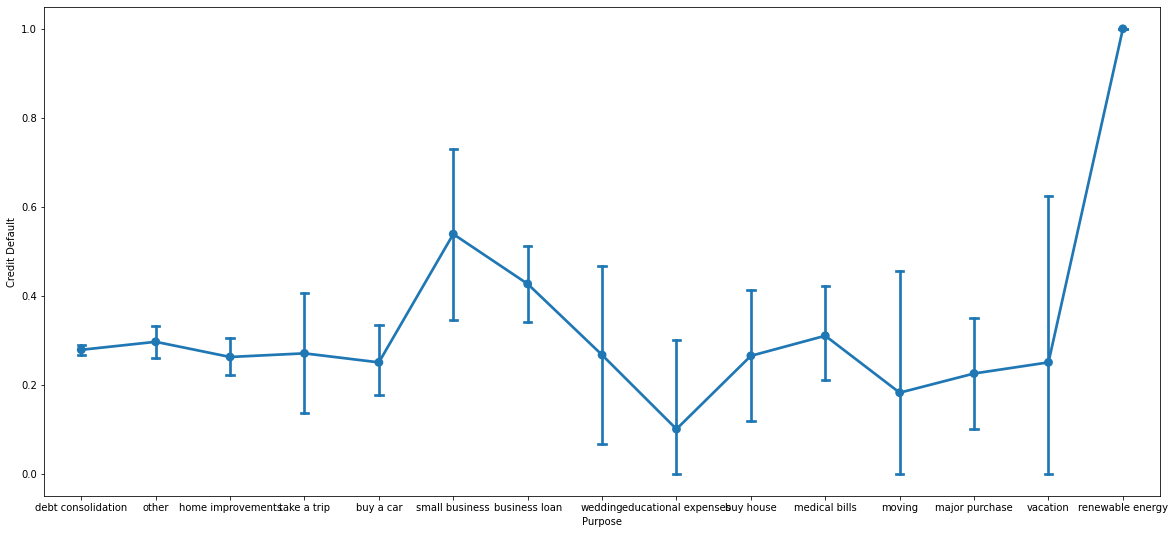

In [10]:
plt.figure(figsize=(20, 9))
sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)

Разделим Purpose на 4 группы: {
                                'debt consolidation':0, 
                                'other':0,
                                'home improvements':0,
                                'business loan':1,
                                'buy a car':0,
                                'medical bills':0,
                                'major purchase':0,
                                'take a trip':0,
                                'buy house':0,
                                'small business':2,
                                'wedding':0,
                                'moving':0,
                                'educational expenses':3,
                                'vacation':0,
                                'renewable energy':2
                                }

**Пропуски**

In [11]:
is_na_set = df_train.isna().sum()
columns_without_na = is_na_set[is_na_set == 0]
is_na_set

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Annual Income

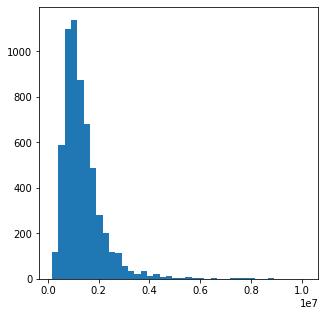

In [12]:
df_train['Annual Income'].hist(figsize=(5, 5), bins=40, grid=False)
plt.show()

Обучим модель для заполнения пропусков

/tmp/ipykernel_52694/2834118455.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_annual_income = df_train[features + ['Annual Income']].corr().iloc[:-1, -1]


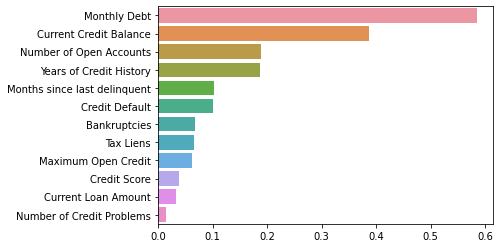

In [13]:
features = df_train.columns.drop('Annual Income').tolist()
corr_annual_income = df_train[features + ['Annual Income']].corr().iloc[:-1, -1]
corr_annual_income = np.abs(corr_annual_income).sort_values(ascending=False)
sns.barplot(x=corr_annual_income.values, y=corr_annual_income.index)
plt.show()

In [14]:
top_features = list(corr_annual_income[corr_annual_income.index != 'Credit Default'].index)
df_annual_income = df_train.loc[(df_train['Annual Income'].notnull()), top_features + ['Annual Income']]
X_ai, y_ai = df_annual_income[top_features], df_annual_income['Annual Income']
X_ai_train, X_ai_test, y_ai_train, y_ai_test = train_test_split(X_ai, y_ai, test_size=0.3, shuffle=True, random_state=42)

In [15]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

Train R2:	0.793
Test R2:	0.405


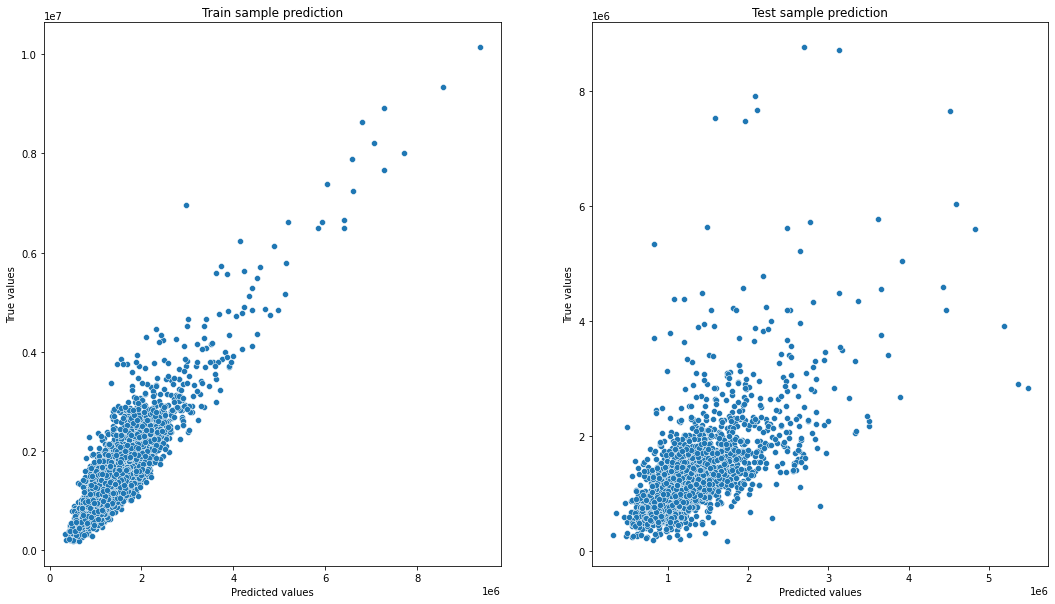

In [16]:
ctbreg_model = CatBoostRegressor(silent=True)
ctbreg_model.fit(X_ai_train, y_ai_train)
y_train_preds = ctbreg_model.predict(X_ai_train)
y_test_preds = ctbreg_model.predict(X_ai_test)
evaluate_preds(y_ai_train, y_train_preds, y_ai_test, y_test_preds)

Credit Score

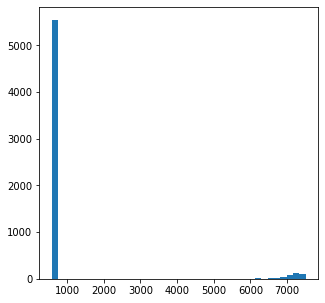

In [17]:
df_train['Credit Score'].hist(figsize=(5, 5), bins=40, grid=False)
plt.show()

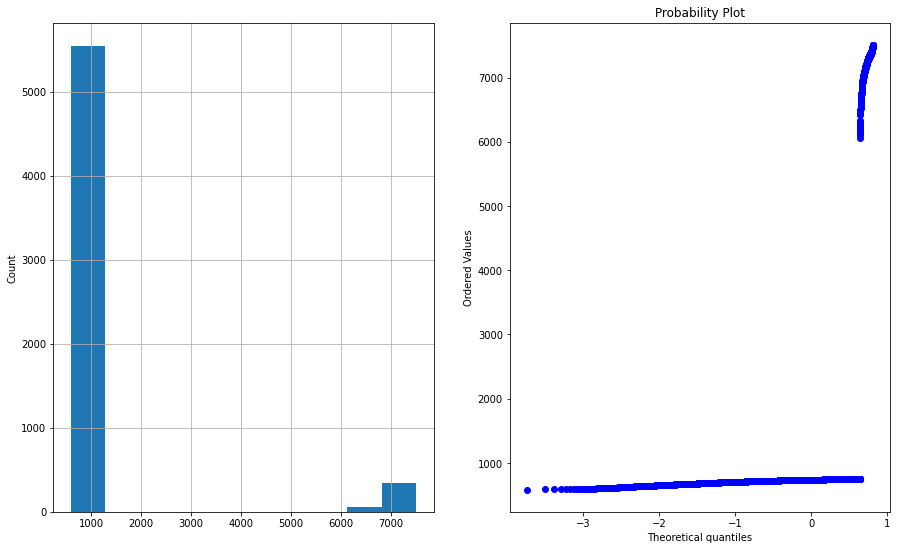

In [18]:
hist_qq(df_train['Credit Score'])

Попробуем заполнить пропуски медианой.

Months since last delinquent

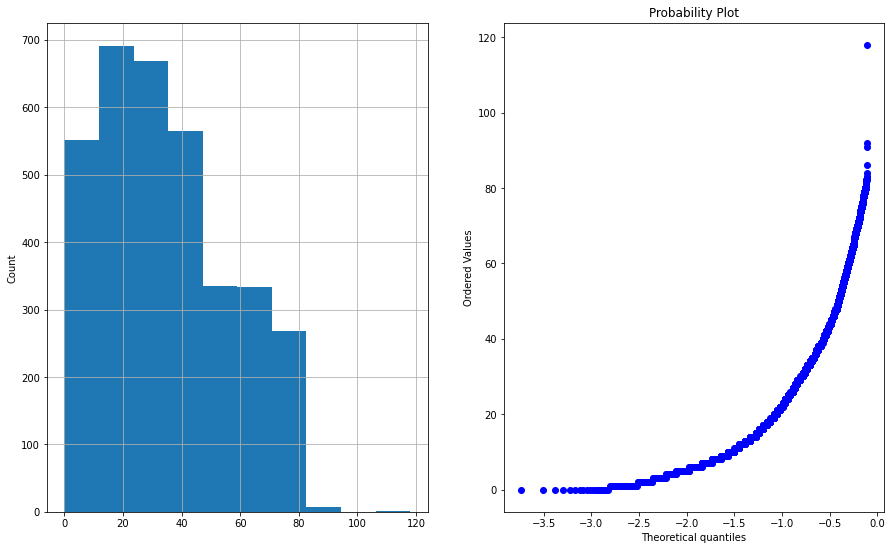

In [19]:
hist_qq(df_train['Months since last delinquent'])

Заполним пропуски максимальными значениями

Bankruptcies

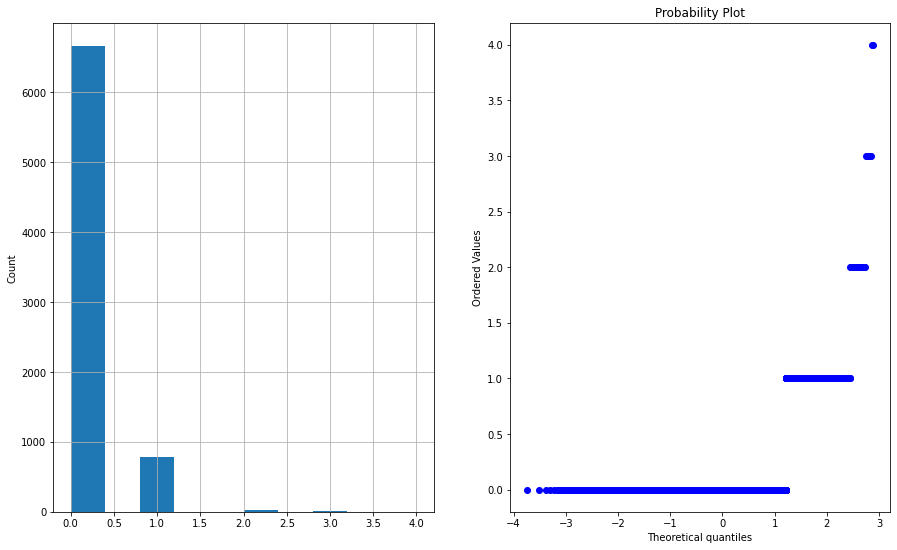

In [20]:
hist_qq(df_train['Bankruptcies'])

Заполним пропуски нулями

<Axes: >

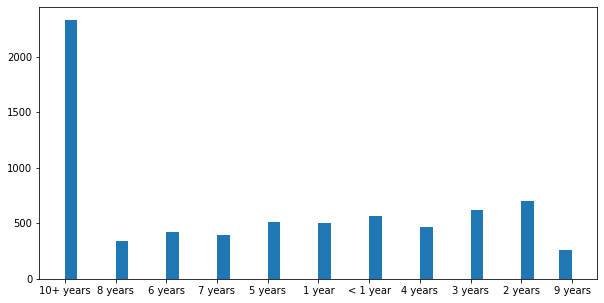

In [21]:
df_train['Years in current job'].hist(figsize=(10, 5), bins=40, grid=False)

Пропуски Years in current Job заполним нулями.

**Класс для обработки данных**

In [22]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1) 


class DataProcessing:
    def __init__(self):
        self.binary_to_numbers = None
        self.purpose_to_replace = {
                                'debt consolidation':0, 
                                'other':0,
                                'home improvements':0,
                                'business loan':1,
                                'buy a car':0,
                                'medical bills':0,
                                'major purchase':0,
                                'take a trip':0,
                                'buy house':0,
                                'small business':2,
                                'wedding':0,
                                'moving':0,
                                'educational expenses':3,
                                'vacation':0,
                                'renewable energy':2
                                }
        self.maximum_open_credit_max = None
        self.max_current_loan_amount = None
        self.month_since_last_delinquent_max = None
        self.credit_score_median = None
        self.credit_score_div = 3500


    def fit(self, X):
        self.binary_to_numbers = {k: v for v, k in enumerate(df_train['Term'].unique())}
        self.maximum_open_credit_max = X['Maximum Open Credit'].quantile(.995)
        self.annual_income_median = X['Annual Income'].median()
        self.month_since_last_delinquent_max = X['Months since last delinquent'].max()
        self.credit_score_median = X['Credit Score'].median()
        ai_features = X.columns.drop('Annual Income').tolist()
        corr_annual_income = X[ai_features + ['Annual Income']].corr().iloc[:-1, -1]
        corr_annual_income = np.abs(corr_annual_income).sort_values(ascending=False)
        self.ai_features = list(corr_annual_income[corr_annual_income.index != 'Credit Default'].index)
        self.ai_features = [i for i in self.ai_features if i not in ['Credit Default', 'Credit Score']]
        df_annual_income = X.loc[(X['Annual Income'].notnull()), self.ai_features + ['Annual Income']]
        X_ai, y_ai = df_annual_income[self.ai_features], df_annual_income['Annual Income']
        self.model_annual_income = CatBoostRegressor(silent=True)
        self.model_annual_income.fit(X_ai, y_ai)
        # X = X.copy()
    

    def _convert_str_to_int(self, years_str):
        if type(years_str) == str:
            years_list = years_str.split(' ')
            for data in years_list:
                if data.isdigit():
                    return int(data)
                if '+' in data:
                    return int(data.replace('+', ''))
                else: return 0
        else: return years_str 
                

    def transform(self, X, target=None):
        X.loc[X['Maximum Open Credit'] > self.maximum_open_credit_max, ['Maximum Open Credit']] = self.maximum_open_credit_max
        X.loc[(X['Annual Income'].isnull()), ['Annual Income']] = self.model_annual_income.predict(X.loc[(X['Annual Income'].isnull()), self.ai_features])
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(self.month_since_last_delinquent_max)
        X['Bankruptcies'] = X['Bankruptcies'].fillna(0)
        X['Credit Score'] = X['Credit Score'].fillna(self.credit_score_median)
        X['Years in current job'] = X['Years in current job'].transform(self._convert_str_to_int)
        X['Years in current job'] = X['Years in current job'].fillna(0)
        X = X.replace(self.binary_to_numbers)
        X = X.replace(self.purpose_to_replace)
        categorial_to_onehot_list = ['Home Ownership']
        for categorial_to_one_hot in categorial_to_onehot_list:
            if categorial_to_one_hot in X.columns:
                pd.concat([X, pd.get_dummies(X[categorial_to_one_hot])], axis=1)
                X = X.drop(columns=[categorial_to_one_hot])
        if target != None:
            X = balance_df_by_target(X, target)
        return X
    

    def get_feature_names(self, X, target):
        return X.columns[(X.columns != target)]

In [23]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [24]:
data_processing = DataProcessing()
data_processing.fit(df_train)
target = 'Credit Default'
df_train = data_processing.transform(df_train, target)
x_columns = data_processing.get_feature_names(df_train, target)

/tmp/ipykernel_52694/1416461687.py:46: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_annual_income = X[ai_features + ['Annual Income']].corr().iloc[:-1, -1]
/tmp/ipykernel_52694/1416461687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


**Разбиение тренировочных данных**

In [25]:
X, y = df_train[x_columns], df_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [26]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

CatBoost

In [27]:
model_catb = CatBoostClassifier(silent=True, random_state=21)#, task_type='GPU')
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3811
           1       0.94      0.81      0.87      2918

    accuracy                           0.89      6729
   macro avg       0.90      0.88      0.89      6729
weighted avg       0.90      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1576
           1       0.79      0.65      0.71      1308

    accuracy                           0.76      2884
   macro avg       0.77      0.75      0.75      2884
weighted avg       0.76      0.76      0.76      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1351  225
1                464  844


**Обучение на тренировочном датасете**

In [28]:
final_model = CatBoostClassifier(silent=True, random_state=21)
final_model.fit(X, y)

**Предсказания на тестовом датасете**

In [30]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = data_processing.transform(df_test)
df_test_x = df_test[x_columns]
y_pred_final = final_model.predict(df_test_x)
predictions = pd.DataFrame({'Id': df_test.index, target: y_pred_final})
predictions.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')